# EXP3. 카메라 스티커 앱 만들기

### 목표
주어진 이미지에서 얼굴을 인식하고 적절한 위치에 수염 스티커 리사이즈해서 붙이기

1. 이미지 구하기
2. dlib를 이용해서 얼굴의 bounding box, landmark 위치 찾기
3. 스티커가 적용될 얼굴의 landmark 계산하기
4. 스티커 사이즈 조절해서 적용하기

### 1. 이미지 가져오기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

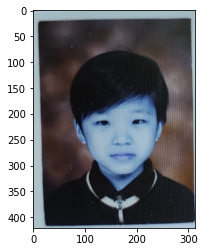

In [2]:
image_path = os.getenv('HOME') + '/aiffel/AI_study/face_sticker/images/image.png'
img_bgr = cv2.imread(image_path, -1)
img_show = img_bgr.copy()
plt.imshow(img_show)
plt.show()

opencv로 이미지를 가져올 때 이미지 채널을   
RGB가 아닌 BGR로 가져와서 퍼렇게 나온다.

cv2.COLOR_BGR2RGB로 채널을 바꿔서 가져오자.   
관련 [opencv 홈페이지](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)

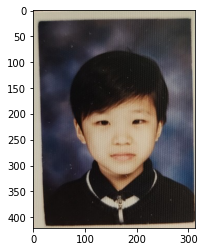

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### 2-1. 얼굴 검출 face detection

앞으로 사용하게 될 dlib의 face detector는 HOG와 SVM을 이용한다.   
HOG(Histogram of Oriented Gradients)는 이미지 색상의 변화량에서 찾는 것이고,   SVM(Support Vector Machine)은 선형 분류기이다.  

HOG를 이용해 이미지를 벡터로 만들고 SVM은 여러 벡터를 구분지으며   
얼굴의 위치를 sliding window로 찾는다.

In [4]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

rectangles[[(110, 182) (239, 311)]]


두 번째 파라미터는 이미지를 upsampling하는 이미지 피라미드의 수이다.   
[더보기](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

<function matplotlib.pyplot.show(close=None, block=None)>

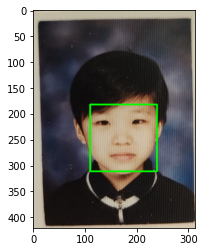

In [5]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show

### 2-2 얼굴 랜드마크 face landmark

스티커를 섬세하게 붙이려면 이목구비를 알아야 한다.   
이를 face landmark localization 기술이라고 한다.   
위에 작업한 detection의 결과물인 bounding box를 이용한다.   

face landmark처럼 객체 내부의 점을 찾는 기술을   
object keypoint estimation이라 한다.
이 keypoint를 찾는 알고리즘은 크게 둘로 나뉘는데,   
1. top-down: bounding box를 찾고 내부에서 keypoint 예측
2. bottom-up: 전체의 keypoint 찾고 point 관계를 군집화 해서 box 만들기

1번을 사용해서 이목구비를 찾을것이다.   
ibug 300w 데이터셋은 68개의 keypoint 사용한다.   
[AFLW dataset](https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/aflw/)

`wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2`   
을 통해 데이터셋을 다운받을 수 있다. bz2 압축파일을 풀어준 뒤 사용하자.

In [6]:
model_path = os.getenv('HOME') + '/aiffel/AI_study/face_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

# 얼굴 박스마다 face landmark 좌표 알아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


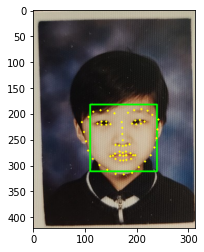

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3. 스티커 적용하기

In [15]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

(173, 251)
(x,y) : (173,186)
(w,h) : (130,130)


In [10]:
sticker_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(130, 130, 3)


In [11]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (108,56)


In [12]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (108,56)


In [13]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
print("슝~")

ValueError: operands could not be broadcast together with shapes (130,130,3) (130,130,4) (130,130,3) 

In [ ]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()